# Plots for temperature anomalies

## Import dependencies and data

In [1]:
# import dependencies
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'

In [3]:
# set seaborn style/theme
sns.set_theme()
sns.set_style('white')

In [27]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [28]:
# keep only flow, setpoints, temps, pressure
data = data[[
    'flow',
    'temperatures',
    'setpoints',
    #'state',
    'pressure',
    'sun',
    'wind',
    'time'
    #'humidity'
]].copy()

## Select and normalize variables

In [29]:
cols = [
    #('flow', 'TA01_GP101_default'),
    #('flow', 'TA01_SP102_absolute'),
    #('flow', 'DC_SP105_absolute'),
    #('flow', 'DC_SP106_absolute'),
    #('flow', 'DC_SP107_absolute'),
    #('flow', 'DC_SP110_absolute'),
    ('flow', 'TA01_GP101'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    #('humidity', 'TA01_GT10X_GM10X'),
    ('pressure', 'DC_GP101'),
    ('sun', 'gsi'),
    ('sun', 'vol'),
     ('wind', 'Wx'),
     ('wind', 'Wy'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    #('setpoints', 'TA01_SP102_calculated'),
    ('time', 'date'),
    ('time', 'mod'),
    ('time', 'doy')
]

data = data[cols].copy()

In [31]:
# # remove level shift from setpoints change
data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures.TA01_GT10X_GM10X \
                                                - (data.setpoints.TA01_GT10X_GM10X - 20.0)

In [32]:
# remove "OUTLIERS" from DC-TEMP
# data[('temperatures', 'DC_GT401_GM401_roll')] = data.temperatures.DC_GT401_GM401.rolling(window=240, center=False).mean()
data[('temperatures', 'DC_GT401_GM401_roll')] = data.temperatures.DC_GT401_GM401.rolling(window=240, center=False).mean()
data[('temperatures', 'DC_diff')] = np.abs(data.temperatures.DC_GT401_GM401 - data.temperatures.DC_GT401_GM401_roll)
data.loc[data.temperatures.DC_diff > 2, ('temperatures', 'DC_GT401_GM401')] = data.temperatures.DC_GT401_GM401_roll


In [34]:
# remove "OUTLIERS" from DC-FLOW
data[('flow', 'TA01_GP101_default')] = data.flow.TA01_GP101.apply(lambda val: max(1800, val))

In [38]:
# perform FFT 
fourier = np.fft.rfft( data.temperatures.DC_GT401_GM401.values)

# get FREQS
spacing = 1 / 100 # i.e. 1/10th of cycle PER step, due to 5-min cycles.
#spacing = 1
freqs = np.fft.rfftfreq(
    n = len(data),
    d = spacing
)

# filter fourier series
threshold = 1
fourier[freqs > threshold] = 0
filtered = np.fft.irfft(fourier)

# put in data
data.loc[:, ('temperatures', 'DC_GT401_GM401_fft')] = 0
data[('temperatures', 'DC_GT401_GM401_fft')] = filtered

In [61]:
# crop data
#data = data.iloc[-14400:].copy()
#data = data.iloc[-4000:].copy()
plotdata = data.iloc[-44000:-41000].copy()
#data = data.iloc[-1000:].copy()

plotdata.index = plotdata.pop(('time', 'date'))

# normalize all columns
for col in plotdata.columns:
   plotdata[col] = (plotdata[col] - plotdata[col].mean()) / plotdata[col].std()

## Plot temp/flow anomalies

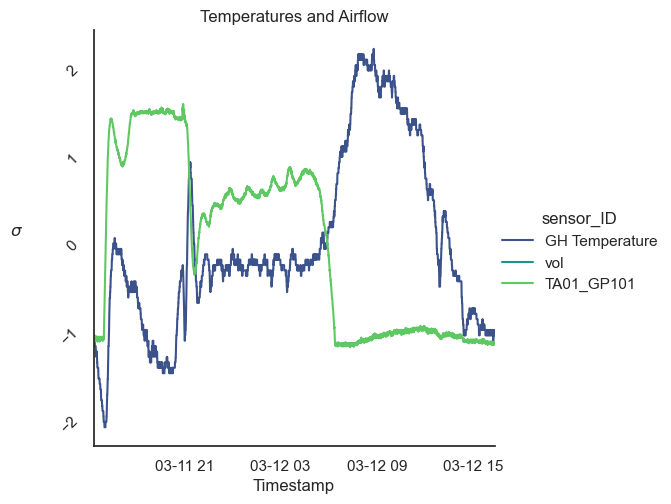

In [66]:
 subset = plotdata[[ # three last days of obs.
 ('temperatures', 'TA01_GT10X_GM10X'),
 # ('temperatures', 'DC_GT401_GM401'),
#    ('temperatures', 'DC_GT401_GM401_roll'),
 #  ('temperatures', 'DC_GT401_GM401_fft'),
  # ('temperatures', 'DC_GT301_damped'),
 #     ('sun', 'gsi'),
     ('sun', 'vol'),
 #    ('wind', 'Wx'),
 #      ('wind', 'Wy'),
 ('flow', 'TA01_GP101'),
 #       ('time', 'doy')
#]].iloc[-7500:-6500].copy()
]].copy()

subset = subset.droplevel(level=0, axis=1)

subset = subset.rename(columns={
    'TA01_GT10X_GM10X':'GH Temperature',
    'DC_GT401_GM401':'DC',
    'DC_GT401_GM401_bound':'DC',
    'DC_GT401_GM401_broll':'DC',
    'TA01_GP101_default':'DC Airflow'
    
})

ax = sns.relplot(
    data=subset,
    kind='line',
    palette='viridis',
    alpha= 1.0,
    linewidth=1.5,
    dashes=False,
    markers=False,
    legend='full',
)

ax.set_xticklabels(step=2)

#plt.ylim(-5, 5)
plt.xlim(subset.index[0], subset.index[-1])
plt.yticks(rotation=45)
plt.xlabel('Timestamp')
plt.ylabel('$\sigma$', loc='center', rotation=0, fontsize=12, labelpad=30)
plt.title('Temperatures and Airflow')

#plt.savefig(plot_path + 'EXAMP_0.png', bbox_inches='tight', dpi=500)
plt.show()

In [586]:
tempVarHourly = data[('temperatures', 'TA01_GT10X_GM10X')].groupby(['month', 'day', 'hour']).std()
flowMeanHourly = data[('flow', 'TA01_GP101_default')].groupby(['month', 'day', 'hour']).std()

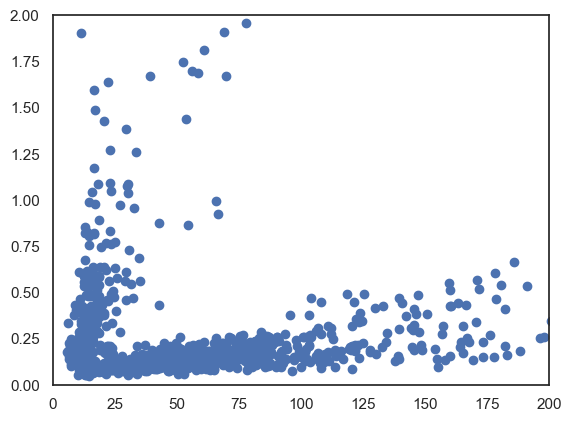

In [593]:
plt.scatter(flowMeanHourly.values, tempVarHourly.values)

plt.xlim(0, 200)
plt.ylim(0, 2)
plt.show()

In [595]:
from sklearn.mixture import GaussianMixture

X = np.hstack((flowMeanHourly.values, tempVarHourly.values))
gm = GaussianMixture(n_components=3, random_state=0).fit(X)

ValueError: Expected 2D array, got 1D array instead:
array=[1.47356983e+02 5.01742619e+01 7.38450278e+01 ... 1.27459006e-01
 2.09334011e-01 1.50886735e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.